In [ ]:
# Install libraries for Grad-CAM and dataset downloading
!pip install grad-cam kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=0247033b3c211bf3182295bcc5b58b13d6a7c4427eb8c3c0bad41f3bbf11c6ed
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import kagglehub

In [ ]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.0001

print(f"Project running on: {DEVICE}")

Project running on: cuda


In [ ]:
# Download the "44 Classes" brain tumor MRI dataset
path = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")
print("Data stored at:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-images-44c' dataset.
Data stored at: /kaggle/input/brain-tumor-mri-images-44c


In [ ]:
class MRIModalityDataset(Dataset):
    def __init__(self, root, modality_suffix, transform=None):
        # Load all 44 folders
        self.full_ds = datasets.ImageFolder(root=root)

        # Filter for classes ending in the specified modality (e.g., " T1")
        self.indices = [i for i, name in enumerate(self.full_ds.classes) if name.endswith(modality_suffix)]
        self.class_names = [self.full_ds.classes[i] for i in self.indices]

        # Filter the actual file samples
        self.samples = [s for s in self.full_ds.samples if s[1] in self.indices]

        # Map original folder IDs to new sequential IDs for the model
        self.label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(self.indices)}
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.label_map[target]
# ImageNet-standard transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_modality_loaders(modality_suffix):
    dataset = MRIModalityDataset(path, modality_suffix, transform=data_transforms)

    # Split: 80% Training, 20% Validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, len(dataset.class_names), dataset.class_names, val_ds

In [ ]:
def train_model(loader, num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(loader):.4f}")

    return model

In [ ]:
def run_gradcam(model, dataset, class_names, num_samples=2):
    model.eval()
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img_tensor, label = dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        # Target the specific label for the visualization
        targets = [ClassifierOutputTarget(label)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Normalize for display
        img_show = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
        vis = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)

        axes[i, 0].imshow(img_show); axes[i, 0].set_title(f"Target: {class_names[label]}")
        axes[i, 1].imshow(vis); axes[i, 1].set_title("Grad-CAM Focus Area")
    plt.tight_layout(); plt.show()


--- TESTING MODALITY: T1 ---
Found 15 tumor types for this modality.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


Epoch [1/5], Loss: 1.1824
Epoch [2/5], Loss: 0.2810
Epoch [3/5], Loss: 0.0987
Epoch [4/5], Loss: 0.0741
Epoch [5/5], Loss: 0.1008


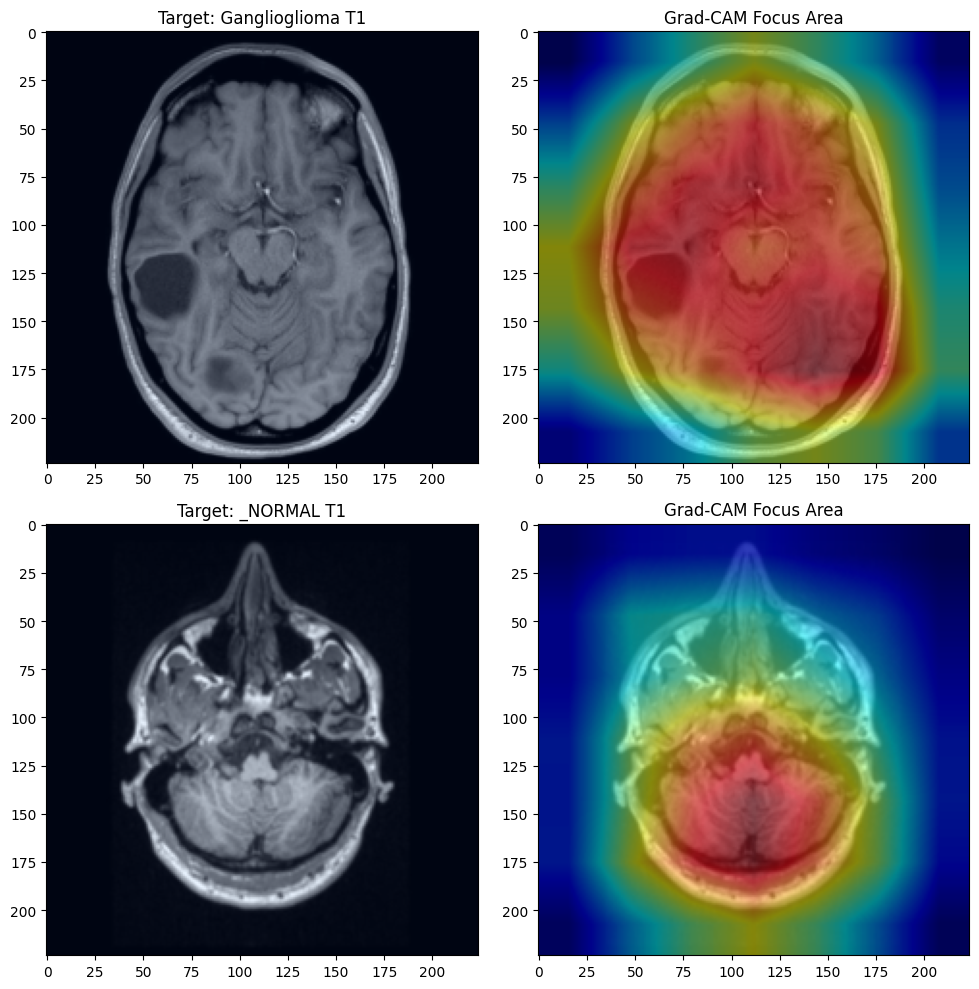


--- TESTING MODALITY: T1C+ ---
Found 14 tumor types for this modality.
Epoch [1/5], Loss: 1.1379
Epoch [2/5], Loss: 0.2224
Epoch [3/5], Loss: 0.0590
Epoch [4/5], Loss: 0.0199
Epoch [5/5], Loss: 0.0146


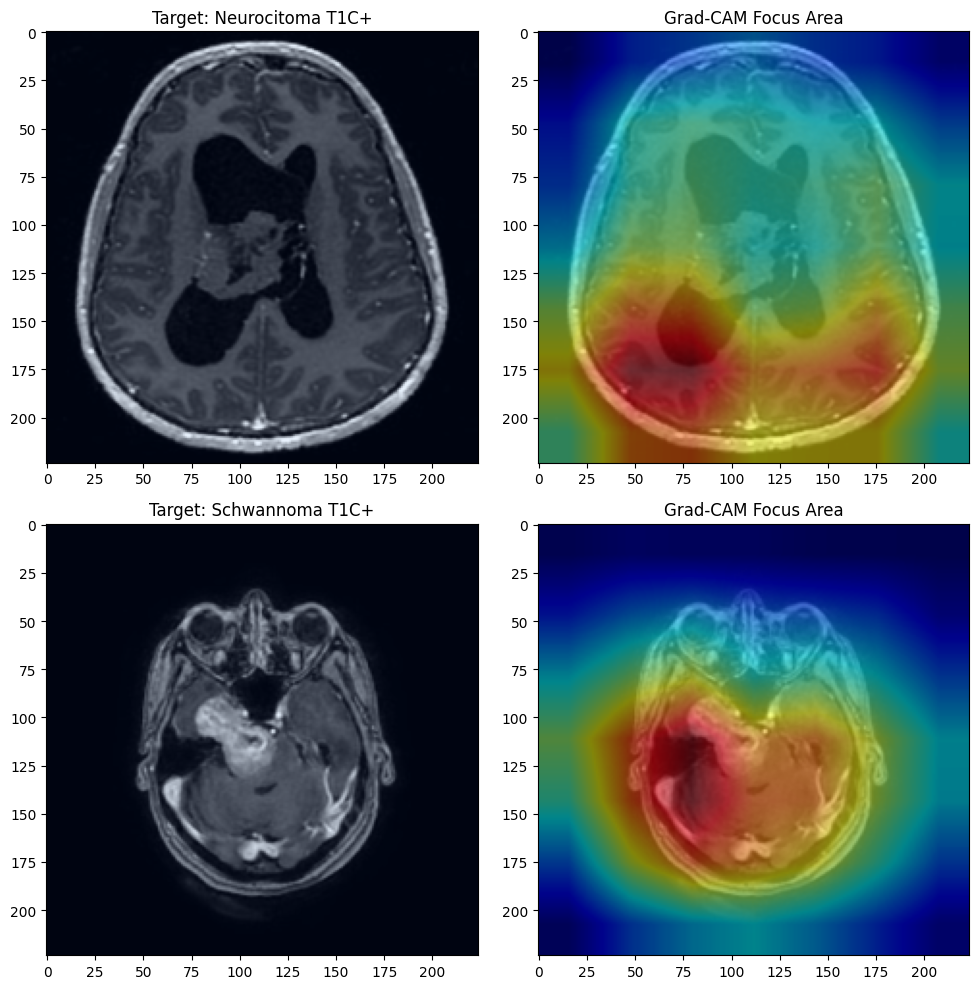

In [ ]:
# Loop through the primary modalities present in your folders
for modality in [" T1", " T1C+"]:
    print(f"\n--- TESTING MODALITY: {modality.strip()} ---")

    # 1. Prepare Loaders
    t_loader, v_loader, n_classes, names, val_subset = get_modality_loaders(modality)
    print(f"Found {n_classes} tumor types for this modality.")

    # 2. Train Model
    trained_m = train_model(t_loader, n_classes)

    # 3. Analyze with Grad-CAM
    run_gradcam(trained_m, val_subset, names)


RUNNING EXPERIMENT: T1
Modality T1 has 15 classes and 1138 training images.
Epoch [1/5], Loss: 1.2269
Epoch [2/5], Loss: 0.2984
Epoch [3/5], Loss: 0.1214
Epoch [4/5], Loss: 0.0413
Epoch [5/5], Loss: 0.0232
Generating Grad-CAM for T1...


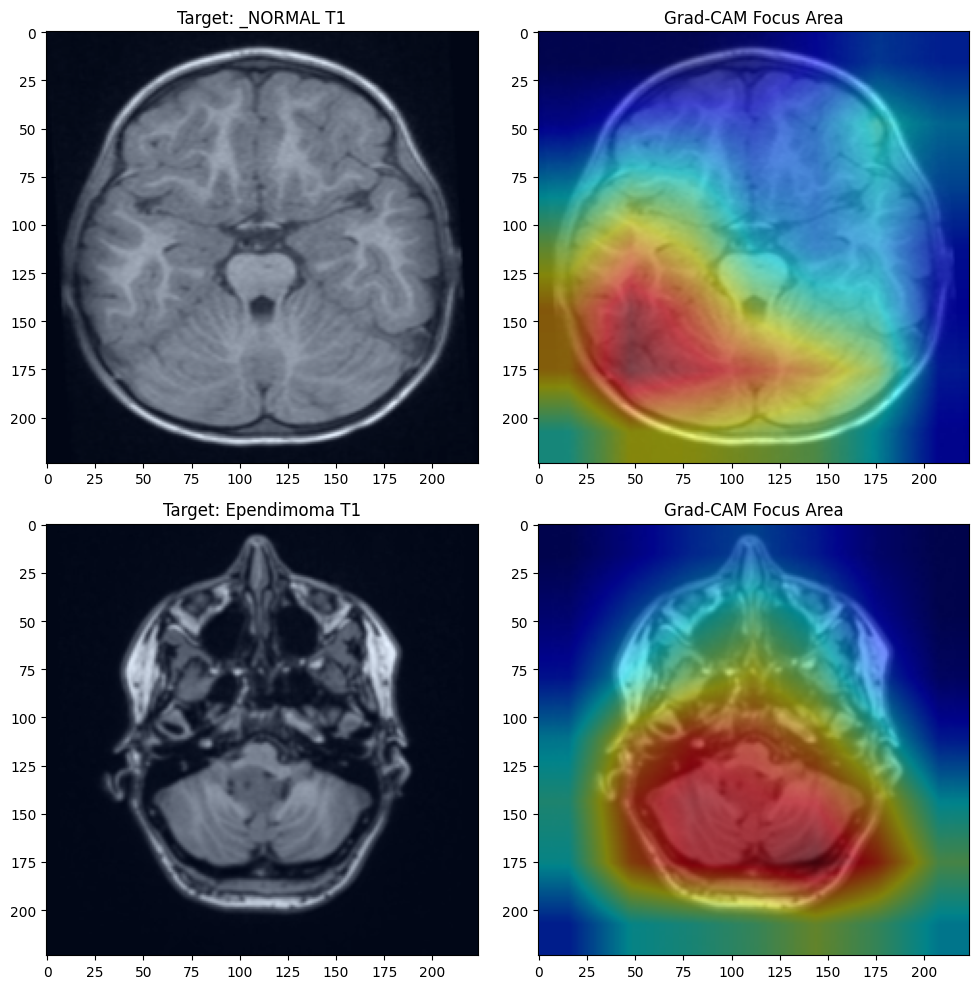

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

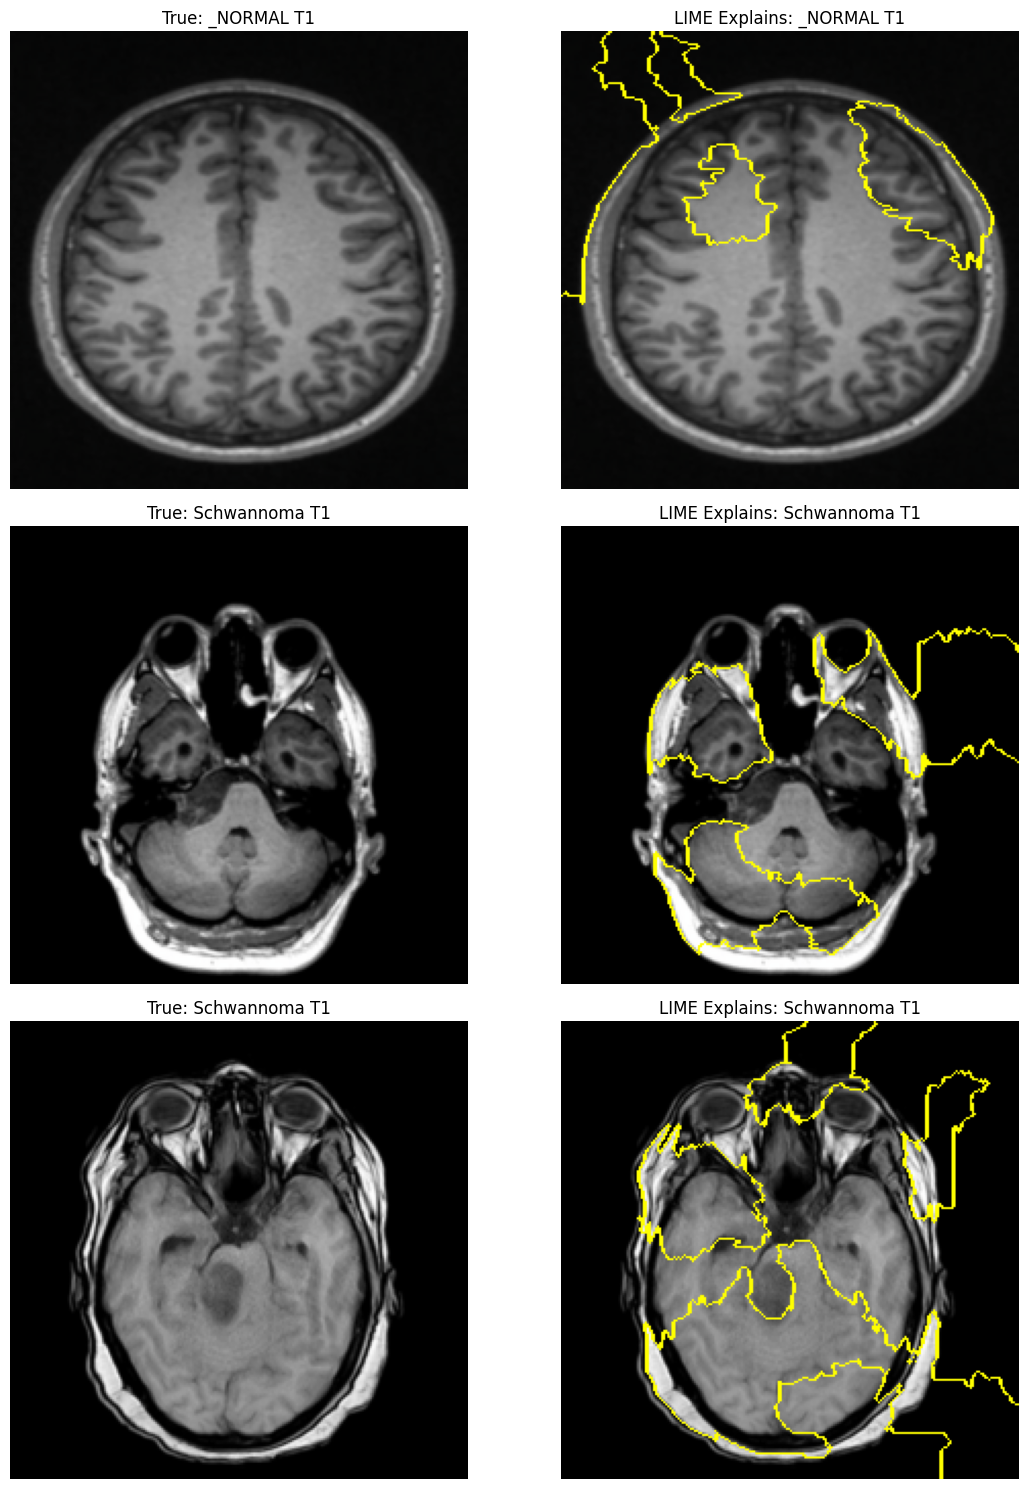

Summarizing performance for T1...

--- Classification Report: T1 ---
                      precision    recall  f1-score   support

      Astrocitoma T1       1.00      0.90      0.95        29
        Carcinoma T1       1.00      0.83      0.91        12
       Ependimoma T1       1.00      0.91      0.95        11
    Ganglioglioma T1       1.00      1.00      1.00         4
        Germinoma T1       1.00      1.00      1.00         3
     Glioblastoma T1       1.00      1.00      1.00        11
        Granuloma T1       1.00      0.70      0.82        10
   Meduloblastoma T1       1.00      1.00      1.00         5
       Meningioma T1       0.89      0.98      0.94        52
      Neurocitoma T1       0.96      0.93      0.95        29
Oligodendroglioma T1       1.00      0.93      0.97        15
         Papiloma T1       0.87      1.00      0.93        13
       Schwannoma T1       0.88      1.00      0.94        30
      Tuberculoma T1       1.00      1.00      1.00         5


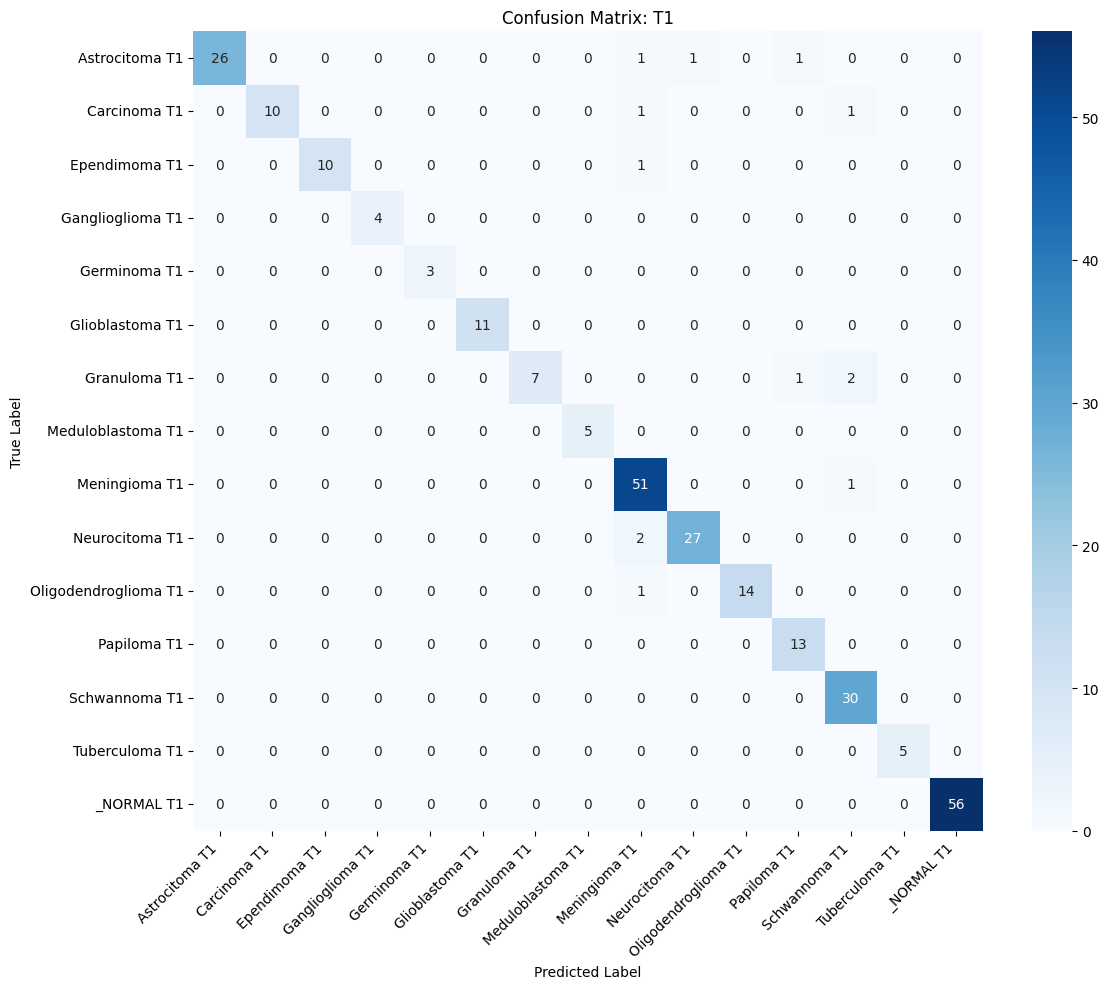


RUNNING EXPERIMENT: T1C+
Modality T1C+ has 14 classes and 1354 training images.
Epoch [1/5], Loss: 1.0994
Epoch [2/5], Loss: 0.2075
Epoch [3/5], Loss: 0.0507
Epoch [4/5], Loss: 0.0171
Epoch [5/5], Loss: 0.0137
Generating Grad-CAM for T1C+...


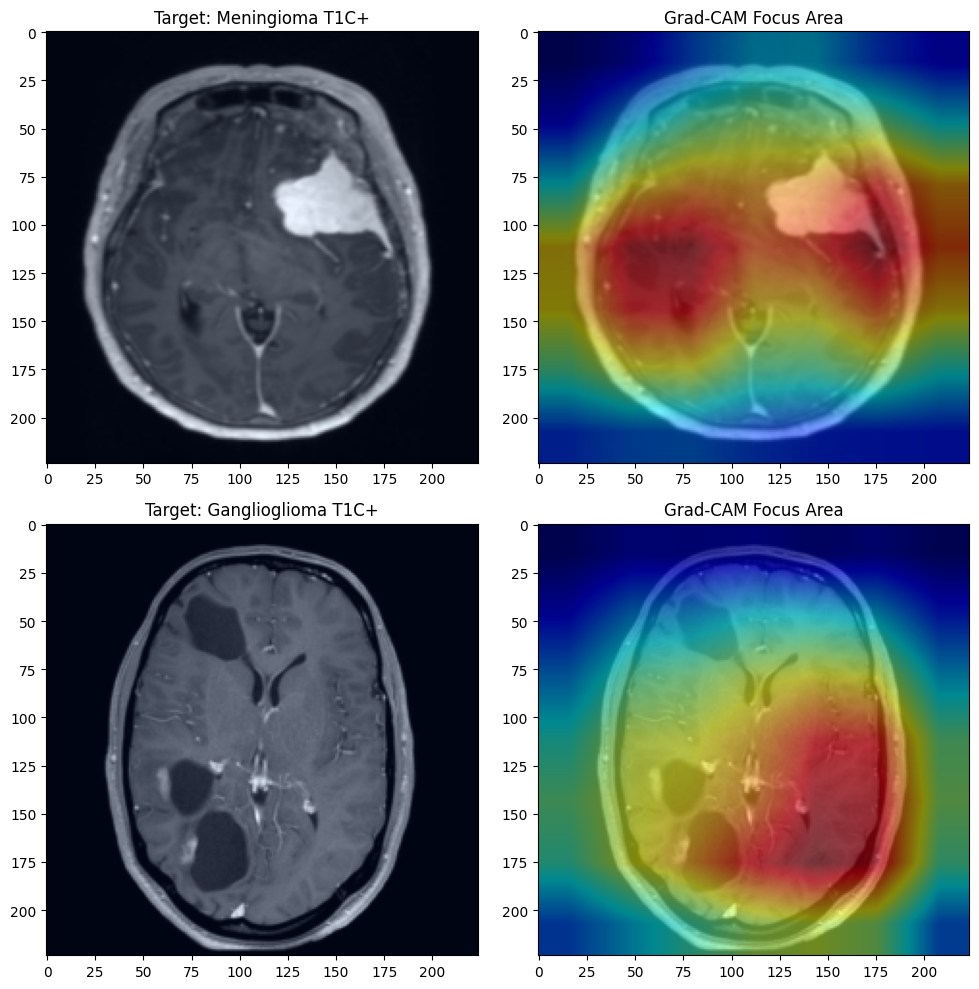

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

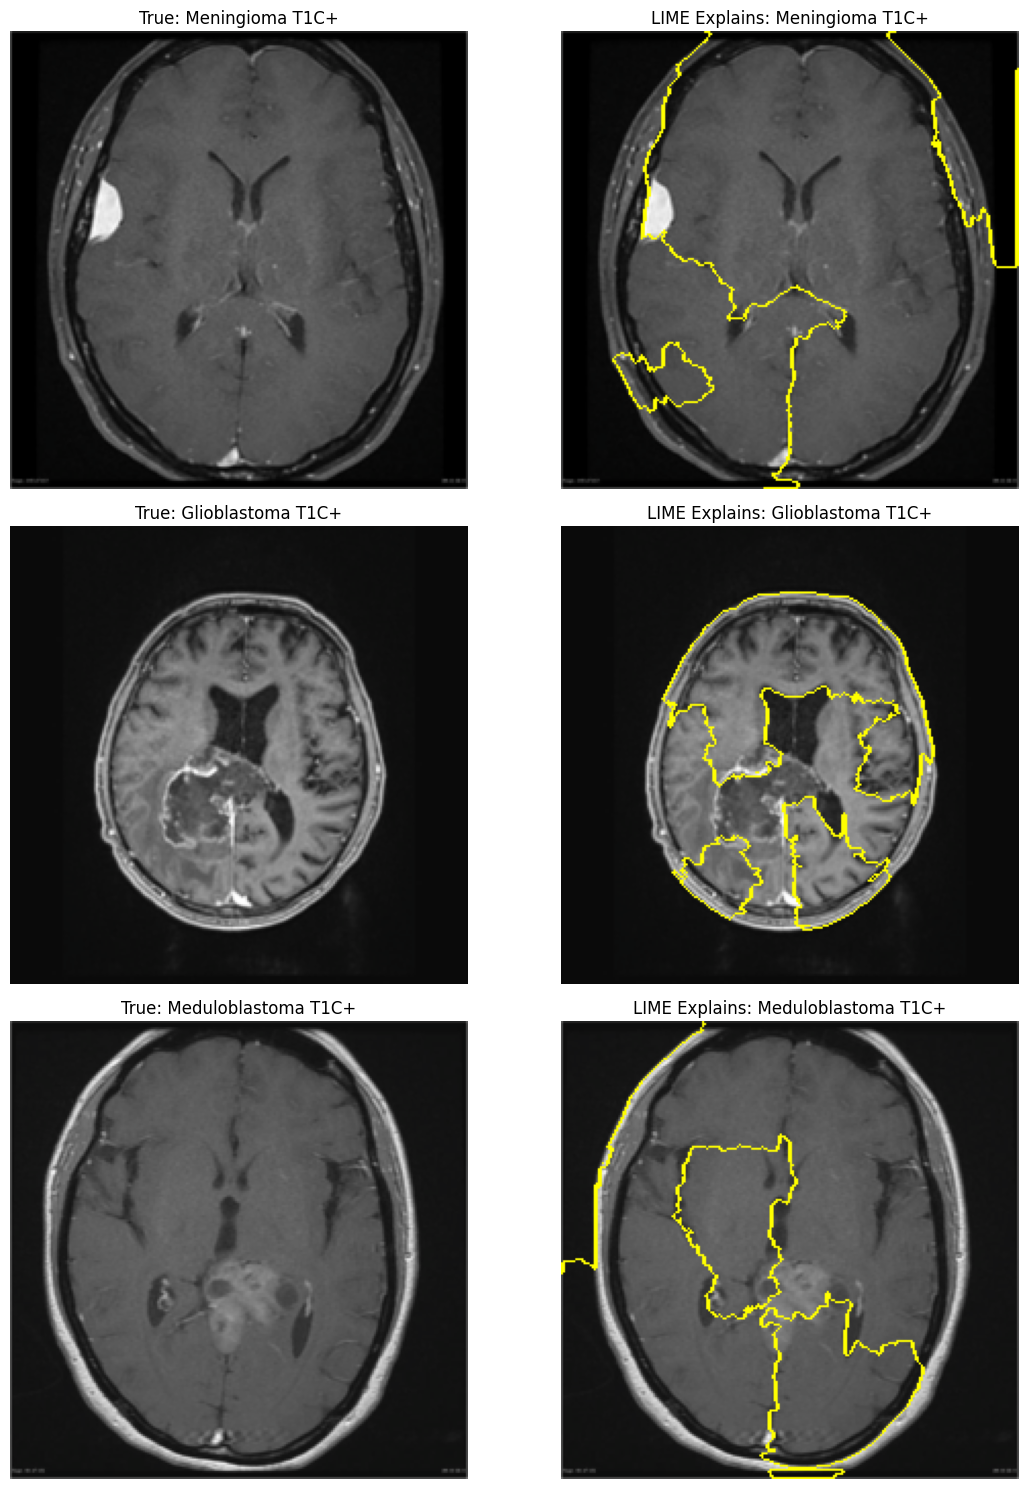

Summarizing performance for T1C+...

--- Classification Report: T1C+ ---
                        precision    recall  f1-score   support

      Astrocitoma T1C+       0.96      1.00      0.98        51
        Carcinoma T1C+       1.00      1.00      1.00        25
       Ependimoma T1C+       0.83      0.83      0.83         6
    Ganglioglioma T1C+       1.00      0.80      0.89        10
        Germinoma T1C+       1.00      0.82      0.90        11
     Glioblastoma T1C+       0.95      1.00      0.98        21
        Granuloma T1C+       0.83      1.00      0.91         5
   Meduloblastoma T1C+       0.92      1.00      0.96        12
       Meningioma T1C+       1.00      0.99      0.99        67
      Neurocitoma T1C+       0.98      1.00      0.99        41
Oligodendroglioma T1C+       1.00      1.00      1.00         9
         Papiloma T1C+       0.96      0.93      0.95        28
       Schwannoma T1C+       0.97      0.97      0.97        40
      Tuberculoma T1C+       1

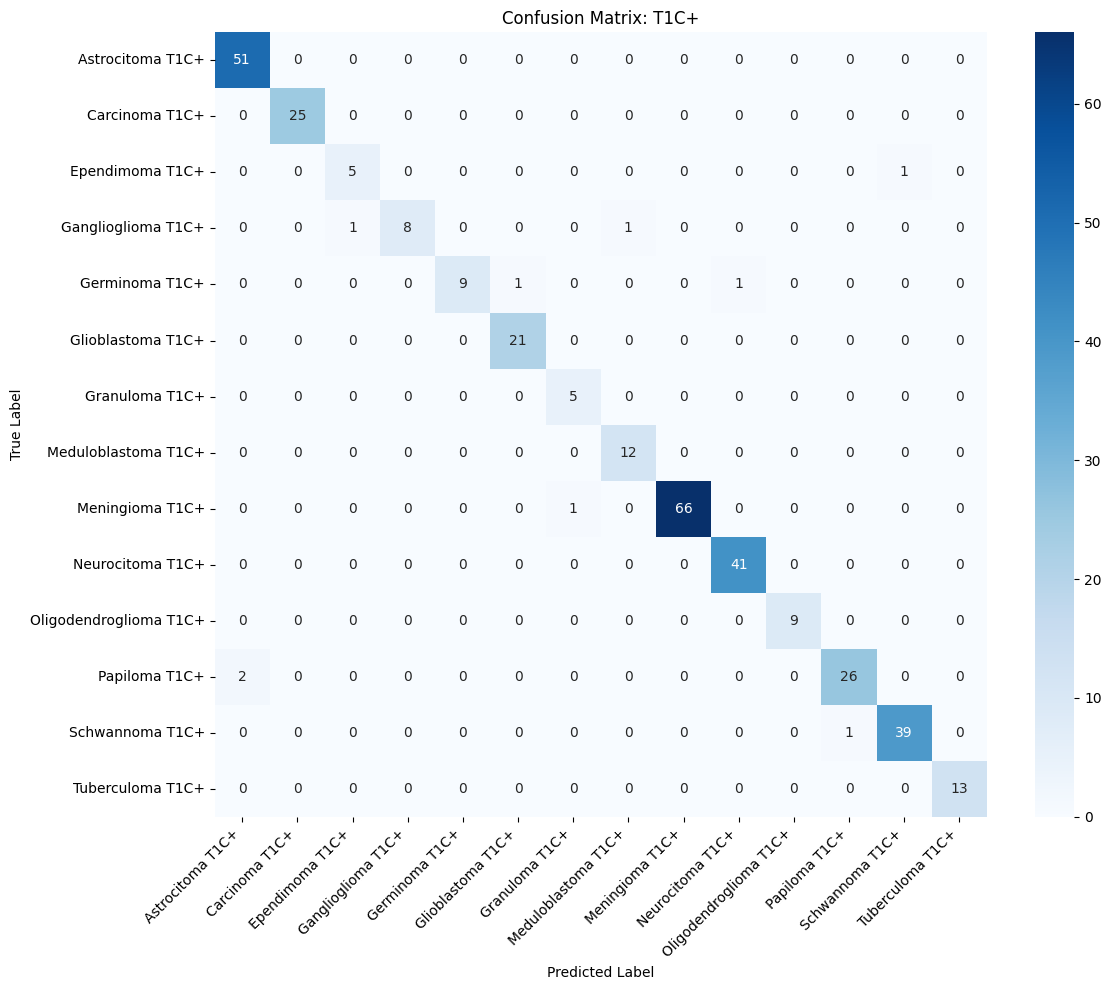


RUNNING EXPERIMENT: T2
Modality T2 has 15 classes and 1090 training images.
Epoch [1/5], Loss: 1.5157
Epoch [2/5], Loss: 0.4349
Epoch [3/5], Loss: 0.1530
Epoch [4/5], Loss: 0.0824
Epoch [5/5], Loss: 0.0737
Generating Grad-CAM for T2...


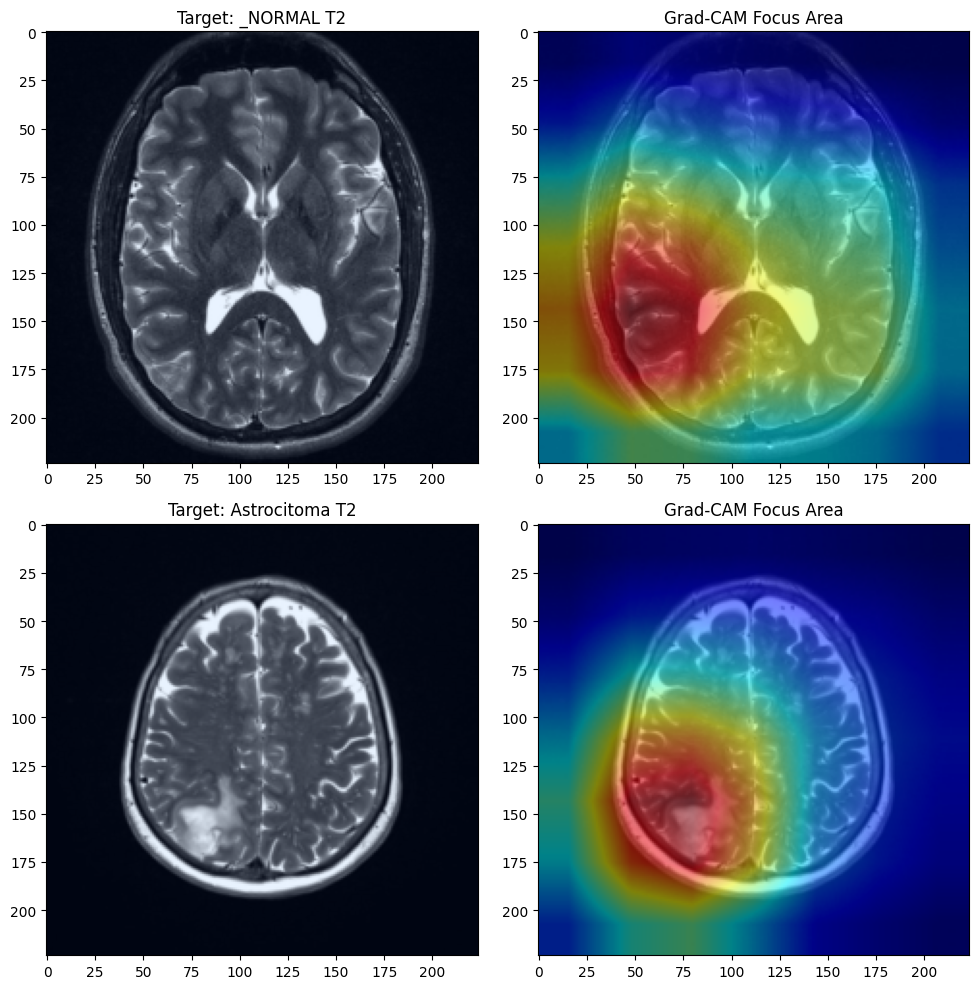

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

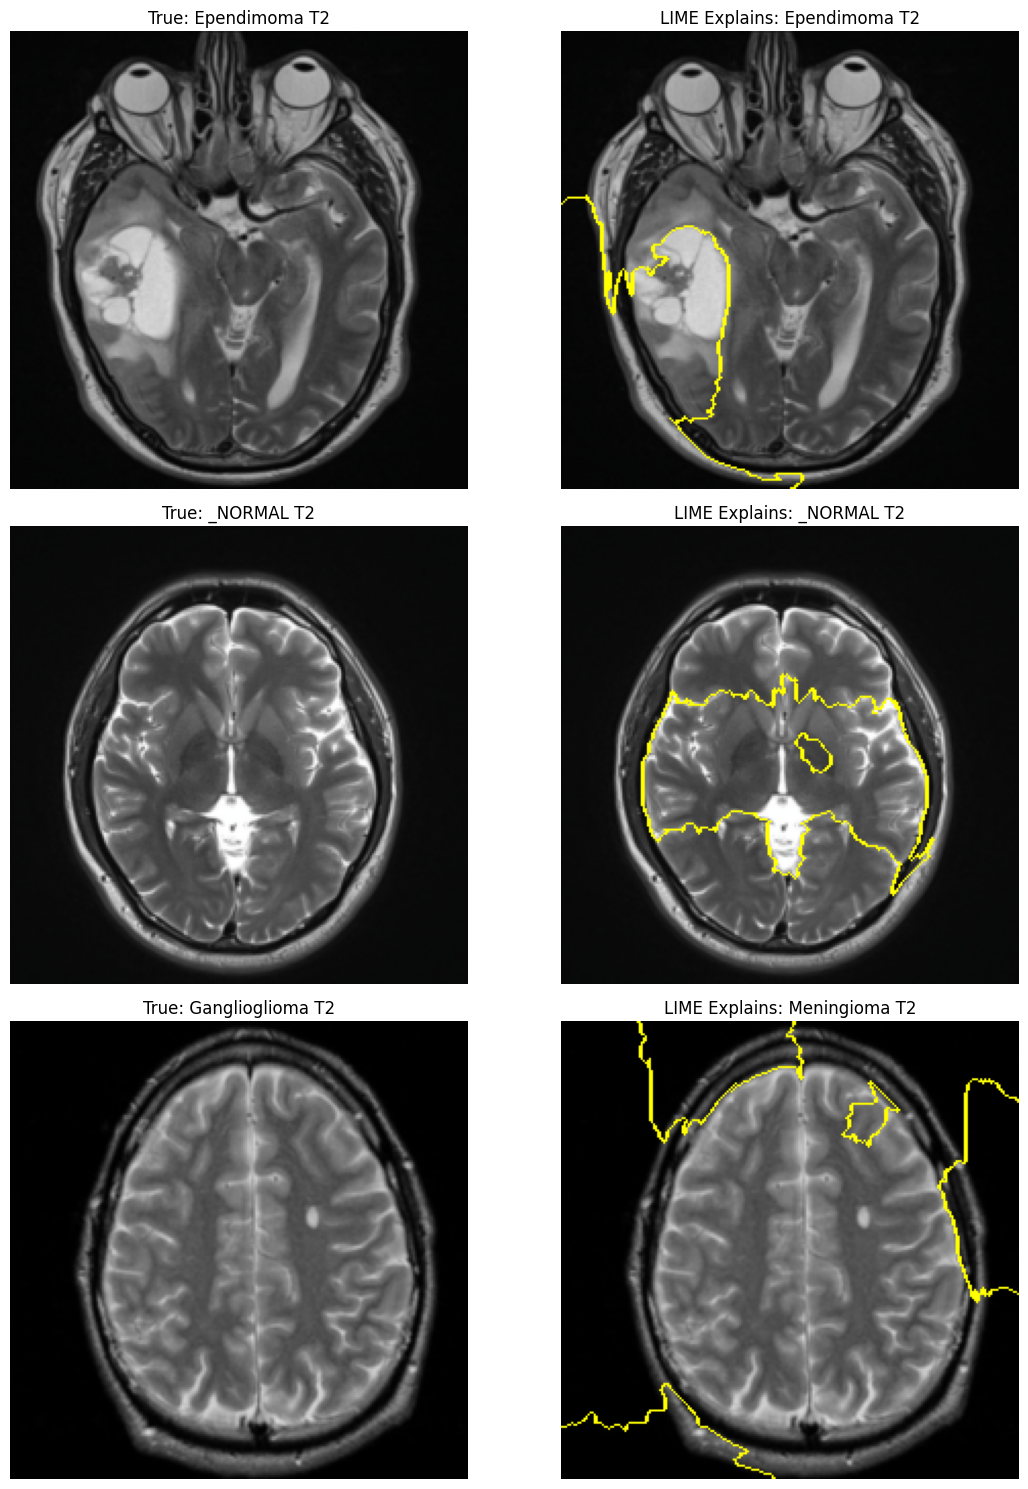

Summarizing performance for T2...

--- Classification Report: T2 ---
                      precision    recall  f1-score   support

      Astrocitoma T2       0.79      0.96      0.87        28
        Carcinoma T2       1.00      0.83      0.91        12
       Ependimoma T2       0.88      1.00      0.93         7
    Ganglioglioma T2       1.00      0.40      0.57         5
        Germinoma T2       1.00      0.56      0.71         9
     Glioblastoma T2       1.00      1.00      1.00         9
        Granuloma T2       1.00      0.43      0.60         7
   Meduloblastoma T2       0.88      0.88      0.88         8
       Meningioma T2       0.82      0.91      0.87        46
      Neurocitoma T2       1.00      0.88      0.94        26
Oligodendroglioma T2       1.00      1.00      1.00        12
         Papiloma T2       0.93      1.00      0.96        13
       Schwannoma T2       0.92      0.88      0.90        25
      Tuberculoma T2       1.00      1.00      1.00         7


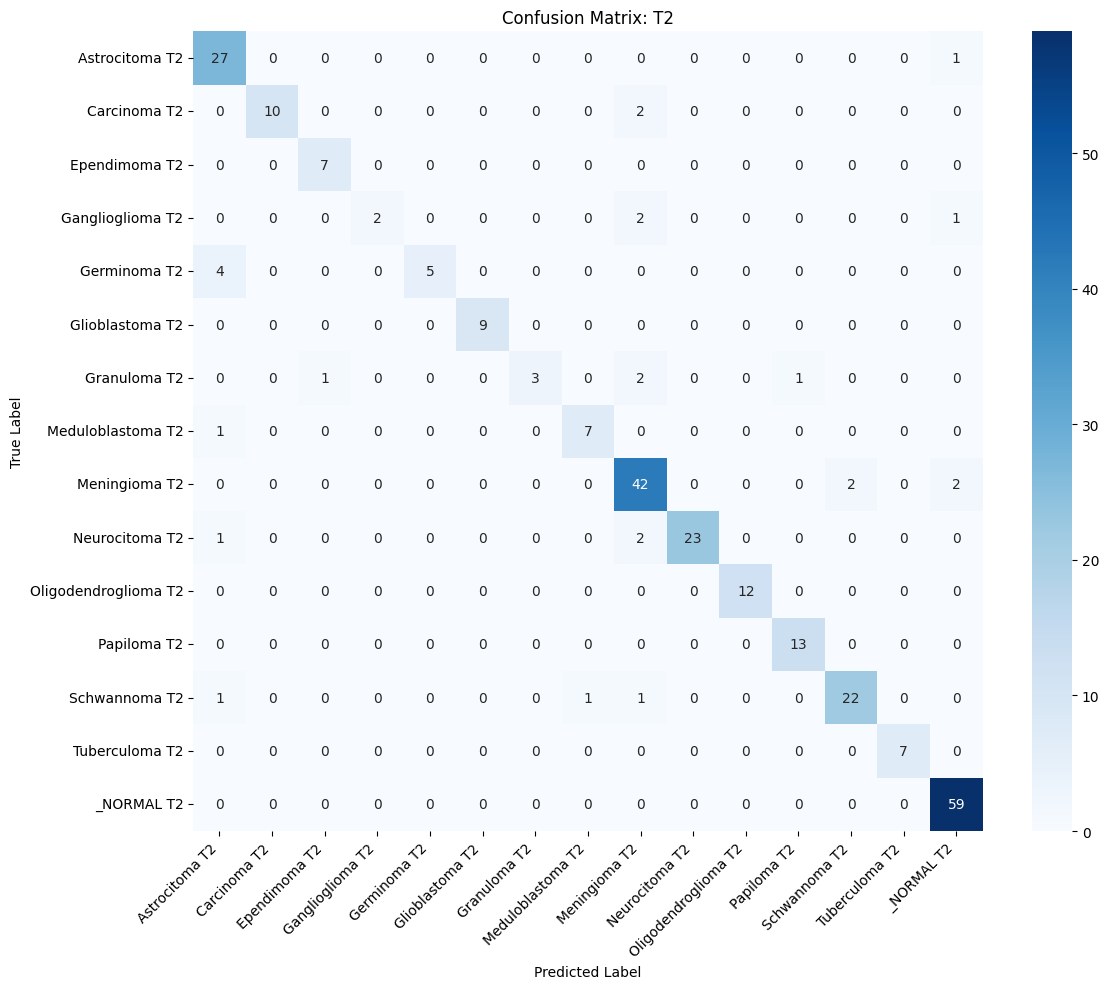

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_performance(model, v_loader, class_names, modality_name):
    model.eval()
    all_preds = []
    all_labels = []

    print(f"Summarizing performance for {modality_name}...")

    with torch.no_grad():
        for images, labels in v_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # 1. Print Text-based Report
    print(f"\n--- Classification Report: {modality_name} ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 2. Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 3. Plot Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {modality_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Update the Execution Loop (Cell 9) to include this:
# Updated Experiment Loop to include T2
# This covers Native T1 (Anatomy), T1C+ (Pathology), and T2 (Fluid/Edema)
for modality in [" T1", " T1C+", " T2"]:
    print(f"\n" + "="*40)
    print(f"RUNNING EXPERIMENT: {modality.strip()}")
    print("="*40)

    # 1. Load Data: Filters folders like 'Astrocitoma T2', 'Glioblastoma T2', etc.
    t_loader, v_loader, n_classes, names, val_subset = get_modality_loaders(modality)
    print(f"Modality {modality.strip()} has {n_classes} classes and {len(t_loader.dataset)} training images.")

    # 2. Train: Transfer learning with ResNet18
    trained_m = train_model(t_loader, n_classes)

    # 3. Visual Analysis (Grad-CAM): Visualizing attention on edema vs core
    print(f"Generating Grad-CAM for {modality.strip()}...")
    run_gradcam(trained_m, val_subset, names)

    visualize_lime(trained_m, val_subset, names)

    # 4. Quantitative Analysis (Confusion Matrix)
    evaluate_model_performance(trained_m, v_loader, names, modality.strip())

# New Section

In [ ]:
!pip install lime scikit-image

from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.transforms import ToPILImage
import numpy as np
import torch

# Constants for de-normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 1. Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

def visualize_lime(model, dataset, class_names, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 5))

    # Helper for PIL conversion
    pil_transform = ToPILImage()

    # Define the prediction function LIME needs [cite: 1, 14]
    def batch_predict(images):
        model.eval()
        batch_tensors = []
        for img in images:
            # Convert numpy array (0-1 float) to 0-255 uint8 for PIL
            img_uint8 = (img * 255).astype(np.uint8)
            pil_img = pil_transform(img_uint8)
            # Apply your project's data_transforms
            t_img = data_transforms(pil_img)
            batch_tensors.append(t_img)

        batch = torch.stack(batch_tensors).to(DEVICE)
        with torch.no_grad():
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    # Sample random images from the provided subset [cite: 8]
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img_tensor, true_label = dataset[idx]

        # De-normalize tensor for LIME display [cite: 63]
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * np.array(IMAGENET_STD)) + np.array(IMAGENET_MEAN)
        img_np = np.clip(img_np, 0, 1)

        # 2. Explain the instance using perturbations [cite: 14]
        explanation = explainer.explain_instance(img_np.astype('double'),
                                                 batch_predict,
                                                 top_labels=1,
                                                 hide_color=0,
                                                 num_samples=500)

        # Get the mask for the top predicted label [cite: 26]
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                   positive_only=True,
                                                   num_features=5,
                                                   hide_rest=False)

        predicted_idx = explanation.top_labels[0]

        # Plotting results [cite: 25, 44, 341]
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"True: {class_names[true_label]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mark_boundaries(temp, mask))
        axes[i, 1].set_title(f"LIME Explains: {class_names[predicted_idx]}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# To run this in your loop, call:
# visualize_lime(trained_m, val_subset, names)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c68c2024da5e8e6fee4b8d29c49bf732eedfcecb4fd2e911c970be9855b9d6fb
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
